## holiday days

In [26]:
import pandas as pd
from datetime import datetime, timedelta


### read data

In [27]:
df_bsr_data = pd.read_csv('../data/trash-amounts.csv', sep=';', dtype=str)
df_holidays = pd.read_csv('../data/holidays.csv', sep=',', quotechar='"')

### clean date column and convert to datetime

In [28]:
df_bsr_data['Datum'] = pd.to_datetime(df_bsr_data['Datum'], format='%d.%m.%y', errors='coerce')

print(df_bsr_data['Datum'].dtype)

datetime64[ns]


### parse holiday periods into a list of dates

In [29]:
def parse_holiday_period(holiday_str, year):
    """
    Wandelt einen Ferien-Zeitraum-String (z.B. "14.04. - 25.04. / 02.05. / 30.05.")
    in eine Liste von (start_date, end_date)-Tupeln um.
    """
    # Vereinheitliche die Trennzeichen
    holiday_str = holiday_str.replace('/', '+')
    parts = holiday_str.split('+')
    intervals = []
    
    for part in parts:
        part = part.strip()
        if not part:
            continue
        if '-' in part:
            start_str, end_str = part.split('-')
            # Entferne überflüssige Punkte und Leerzeichen
            start_str = start_str.strip().rstrip('.')
            end_str = end_str.strip().rstrip('.')
            # Erzeuge Start- und Enddatum
            start_date = datetime.strptime(f"{start_str}.{year}", "%d.%m.%Y")
            end_date = datetime.strptime(f"{end_str}.{year}", "%d.%m.%Y")
            # Falls das Enddatum vor dem Startdatum liegt (z.B. 23.12. - 04.01.), 
            # dann ordne das Enddatum dem Folgejahr zu.
            if start_date > end_date:
                end_date = datetime.strptime(f"{end_str}.{year+1}", "%d.%m.%Y")
            intervals.append((start_date, end_date))
        else:
            # Einzeltermin – hier ebenfalls überflüssige Punkte entfernen
            date_str = part.strip().rstrip('.')
            date_obj = datetime.strptime(f"{date_str}.{year}", "%d.%m.%Y")
            intervals.append((date_obj, date_obj))
    return intervals

### collect all dates into a dictionary

In [30]:
holidays = {}

for idx, row in df_holidays.iterrows():
    bundesland = row['Bundesland']
    year = int(row['Jahr'])
    if bundesland not in holidays:
        holidays[bundesland] = {}
    if year not in holidays[bundesland]:
        holidays[bundesland][year] = set()
        
    # Alle Ferien-Spalten (ab der 3. Spalte) durchgehen
    for col in df_holidays.columns[2:]:
        # Prüfen, ob in der Spalte ein Wert steht
        if pd.isna(row[col]):
            continue
        holiday_str = row[col]
        intervals = parse_holiday_period(holiday_str, year)
        for start_date, end_date in intervals:
            # Füge alle Tage im Intervall (inklusive Start und Ende) hinzu
            delta_days = (end_date - start_date).days
            for i in range(delta_days + 1):
                tag = start_date + timedelta(days=i)
                holidays[bundesland][year].add(tag)

### create a new dataframe with all dates

In [31]:
result_rows = []
for bundesland, years in holidays.items():
    for year, holiday_set in years.items():
        start_year = datetime(year, 1, 1)
        end_year = datetime(year, 12, 31)
        for tag in pd.date_range(start_year, end_year):
            tag_dt = tag.to_pydatetime()
            result_rows.append({
                'Bundesland': bundesland,
                'Datum': tag,
                'is_holiday': tag_dt in holiday_set
            })

result_df = pd.DataFrame(result_rows)
print(result_df.head(20))

   Bundesland      Datum  is_holiday
0      Berlin 2019-01-01       False
1      Berlin 2019-01-02       False
2      Berlin 2019-01-03       False
3      Berlin 2019-01-04       False
4      Berlin 2019-01-05       False
5      Berlin 2019-01-06       False
6      Berlin 2019-01-07       False
7      Berlin 2019-01-08       False
8      Berlin 2019-01-09       False
9      Berlin 2019-01-10       False
10     Berlin 2019-01-11       False
11     Berlin 2019-01-12       False
12     Berlin 2019-01-13       False
13     Berlin 2019-01-14       False
14     Berlin 2019-01-15       False
15     Berlin 2019-01-16       False
16     Berlin 2019-01-17       False
17     Berlin 2019-01-18       False
18     Berlin 2019-01-19       False
19     Berlin 2019-01-20       False


In [32]:
# Merge df_bsr_data with result_df on the 'Datum' column
df_bsr_data = df_bsr_data.merge(result_df[['Datum', 'is_holiday']], on='Datum', how='left', suffixes=('', '_y'))

# Drop the duplicate 'is_holiday_y' column if it exists
df_bsr_data.drop(columns=['is_holiday_y'], inplace=True, errors='ignore')

print(df_bsr_data.head())

  Monat KW  Jahr      Datum  Hof Schicht Tour Tonnage Abfallart is_holiday
0     1  1  2019 2019-01-02  VMF       1    1    5,59       BIO      False
1     1  1  2019 2019-01-02  VMF       1    4    3,23       BIO      False
2     1  1  2019 2019-01-02  VMF       1    5    5,68       BIO      False
3     1  1  2019 2019-01-02  VMF       1    6    5,48       BIO      False
4     1  1  2019 2019-01-02  VMF       1    7    7,84       BIO      False


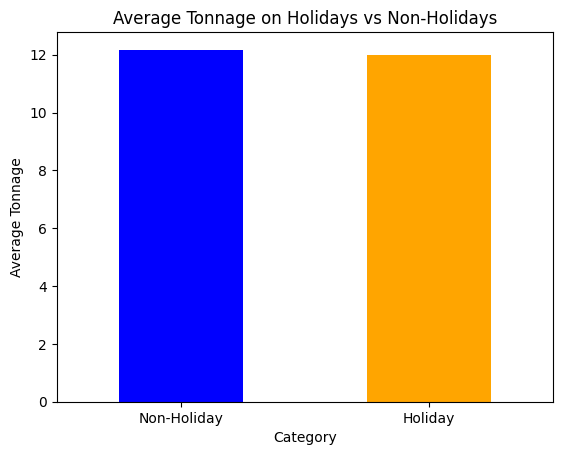

In [33]:
import matplotlib.pyplot as plt

# Konvertiere die Tonnage-Spalte in numerische Werte
df_bsr_data['Tonnage'] = pd.to_numeric(df_bsr_data['Tonnage'].str.replace(',', '.'), errors='coerce')

# Gruppiere die Daten nach Feiertagen und berechne die durchschnittliche Müllmenge
average_tonnage = df_bsr_data.groupby('is_holiday')['Tonnage'].mean()

# Plotten der Ergebnisse
average_tonnage.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Category')
plt.ylabel('Average Tonnage')
plt.title('Average Tonnage on Holidays vs Non-Holidays')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.show()

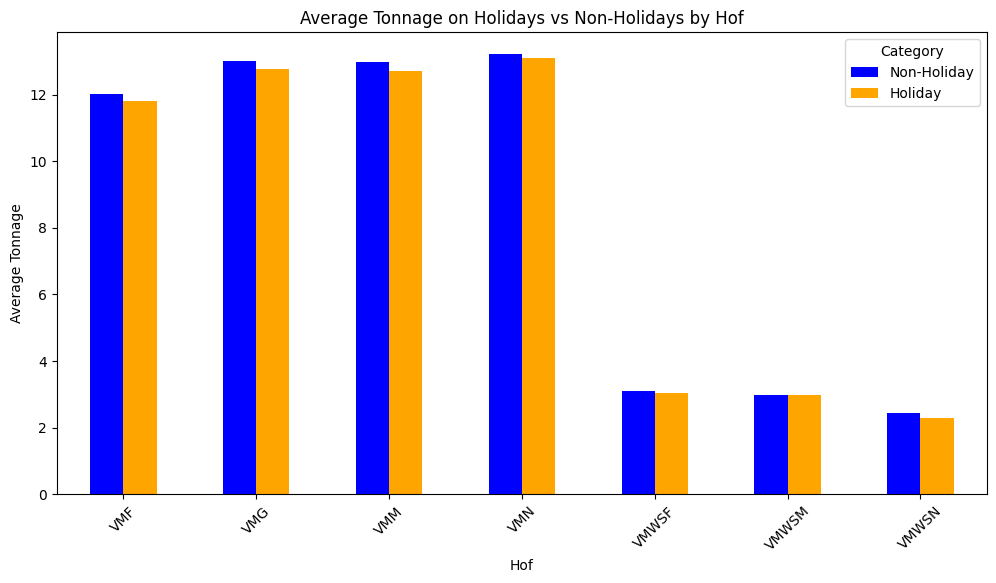

In [34]:
# Gruppiere die Daten nach Hof und Feiertagen und berechne die durchschnittliche Müllmenge
average_tonnage_by_hof = df_bsr_data.groupby(['Hof', 'is_holiday'])['Tonnage'].mean().unstack()

# Plotten der Ergebnisse
average_tonnage_by_hof.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])
plt.xlabel('Hof')
plt.ylabel('Average Tonnage')
plt.title('Average Tonnage on Holidays vs Non-Holidays by Hof')
plt.xticks(rotation=45)
plt.legend(title='Category', labels=['Non-Holiday', 'Holiday'])
plt.show()